In [ ]:
!unzip -uq "/content/plant_data.zip" -d "/content"

In [ ]:
# ==============================================================================
# PART 1: SETUP & TRAINING
# ==============================================================================
!pip install torch transformers pillow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import json
import os
import random

# 1. SETUP DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using Device: {device}")

# 2. TOKENIZER
class SimpleTokenizer:
    def __init__(self, jsonl_path):
        self.word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}

        print("📖 Building Vocabulary...")
        with open(jsonl_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                text = entry['cot'].lower().replace(".", " .").replace(",", " ,")
                for word in text.split():
                    if word not in self.word2idx:
                        idx = len(self.word2idx)
                        self.word2idx[word] = idx
                        self.idx2word[idx] = word
        print(f"✅ Vocab Size: {len(self.word2idx)}")

    def encode(self, text):
        text = text.lower().replace(".", " .").replace(",", " ,")
        tokens = ["<SOS>"] + text.split() + ["<EOS>"]
        return [self.word2idx.get(w, 3) for w in tokens]

    def decode(self, token_ids):
        words = []
        for idx in token_ids:
            if isinstance(idx, torch.Tensor): idx = idx.item()
            if idx == 2: break
            if idx not in [0, 1, 2]:
                words.append(self.idx2word.get(idx, "<UNK>"))
        return " ".join(words)

# ---------------- CONFIGURATION ----------------
jsonl_path = "/content/plant_data/data.jsonl"
image_root = "/content/plant_data/"
# -----------------------------------------------

tokenizer = SimpleTokenizer(jsonl_path)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 3. DATASET
class PlantGenDataset(Dataset):
    def __init__(self, jsonl_path, root_dir, tokenizer, processor):
        self.root_dir = root_dir#loading the directory
        self.tokenizer = tokenizer#stores the custom tokenizer
        self.processor = processor#Clip model for preparing image+question
        self.data = [json.loads(line) for line in open(jsonl_path, 'r')]#Reads every line of data.jsonl and saves it as a dictionary

    def __len__(self): return len(self.data)#used to find out the size of

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.root_dir, item['image'])
        try: image = Image.open(img_path).convert("RGB")#it will try to take the image and convert it into rgb
        except: image = Image.new('RGB', (224, 224), color='black')#if not it will just add a black image

        inputs = self.processor(text=item['question'], images=image, return_tensors="pt", padding="max_length", truncation=True)#we are passing parameters to the clip model
        target_ids = self.tokenizer.encode(item['cot'])#tokenized chain of thought

        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'target_ids': torch.tensor(target_ids, dtype=torch.long)
        }

def collate_fn(batch):
    pix = torch.stack([x['pixel_values'] for x in batch])
    ids = torch.stack([x['input_ids'] for x in batch])
    mask = torch.stack([x['attention_mask'] for x in batch])
    targets = pad_sequence([x['target_ids'] for x in batch], batch_first=True, padding_value=0)
    return pix, ids, mask, targets

dataset = PlantGenDataset(jsonl_path, image_root, tokenizer, processor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# 4. MODEL ARCHITECTURE
class RecursiveReasoningLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_steps=3):
        super().__init__()
        self.num_steps = num_steps
        self.gru = nn.GRUCell(input_dim, hidden_dim)

    def forward(self, x):
        hidden = torch.zeros(x.size(0), self.gru.hidden_size).to(x.device)
        for _ in range(self.num_steps): hidden = self.gru(x, hidden)
        return hidden

class PlantGenerator(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        for p in self.clip.parameters(): p.requires_grad = False

        self.reasoning = RecursiveReasoningLayer(1024, 512)
        self.embedding = nn.Embedding(vocab_size, 256)
        self.decoder = nn.GRU(256 + 512, 512, batch_first=True)
        self.fc_out = nn.Linear(512, vocab_size)

    def forward(self, pix, ids, mask, target_ids):
        with torch.no_grad():
            img_f = self.clip.get_image_features(pix)
            txt_f = self.clip.get_text_features(ids, mask)

        context = self.reasoning(torch.cat((img_f, txt_f), dim=1))
        embeds = self.embedding(target_ids)
        seq_len = embeds.size(1)

        # Concat Context to every input word
        context_expanded = context.unsqueeze(1).repeat(1, seq_len, 1)
        rnn_input = torch.cat((embeds, context_expanded), dim=2)

        rnn_out, _ = self.decoder(rnn_input, context.unsqueeze(0))
        return self.fc_out(rnn_out)

    def generate_greedy(self, pix, ids, mask, max_len=40):
        # Deterministic Generation (For Testing)
        with torch.no_grad():
            img_f = self.clip.get_image_features(pix)
            txt_f = self.clip.get_text_features(ids, mask)
            context = self.reasoning(torch.cat((img_f, txt_f), dim=1))

            curr_token = torch.tensor([[1]]).to(pix.device)
            hidden = context.unsqueeze(0)
            generated_ids = []

            for _ in range(max_len):
                embed = self.embedding(curr_token)
                rnn_input = torch.cat((embed, context.unsqueeze(1)), dim=2)
                out, hidden = self.decoder(rnn_input, hidden)
                next_id = torch.argmax(self.fc_out(out), dim=2)
                generated_ids.append(next_id.item())
                if next_id.item() == 2: break
                curr_token = next_id
            return generated_ids

    def generate_for_rl(self, pix, ids, mask, max_len=40):
        # Probabilistic Generation (For RL)
        with torch.no_grad():
            img_f = self.clip.get_image_features(pix)
            txt_f = self.clip.get_text_features(ids, mask)
            context = self.reasoning(torch.cat((img_f, txt_f), dim=1))

        curr_token = torch.tensor([[1]]).to(pix.device)
        hidden = context.unsqueeze(0)
        log_probs = []
        generated_ids = []

        for _ in range(max_len):
            embed = self.embedding(curr_token)
            rnn_input = torch.cat((embed, context.unsqueeze(1)), dim=2)
            out, hidden = self.decoder(rnn_input, hidden)
            logits = self.fc_out(out).squeeze(1)

            # Sample from distribution
            m = torch.distributions.Categorical(logits=logits)
            action = m.sample()

            log_probs.append(m.log_prob(action))
            generated_ids.append(action.item())
            if action.item() == 2: break
            curr_token = action.unsqueeze(1)

        return generated_ids, torch.stack(log_probs)

model = PlantGenerator(len(tokenizer.word2idx)).to(device)

# 5. TRAINING LOOP
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

print("🚀 Starting  Training (The Teacher)...")
model.train()

# ⚠️ INCREASE EPOCHS: We need the loss < 1.0 before RL
EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:
        pix, ids, mask, targets = [x.to(device) for x in batch]

        optimizer.zero_grad()

        # Teacher Forcing: Predict next word
        inputs_seq = targets[:, :-1]
        targets_seq = targets[:, 1:]

        logits = model(pix, ids, mask, inputs_seq)
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets_seq.reshape(-1))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f}")

print(" Training Finished!")

✅ Using Device: cuda
📖 Building Vocabulary...
✅ Vocab Size: 374
🚀 Starting Supervised Training (The Teacher)...
Epoch 5/50 | Loss: 3.2666
Epoch 10/50 | Loss: 2.3111
Epoch 15/50 | Loss: 1.6305
Epoch 20/50 | Loss: 1.0305
Epoch 25/50 | Loss: 0.7873
Epoch 30/50 | Loss: 0.6144
Epoch 35/50 | Loss: 0.4668
Epoch 40/50 | Loss: 0.3617
Epoch 45/50 | Loss: 0.3039
Epoch 50/50 | Loss: 0.2616
✅ Supervised Training Finished!


In [ ]:
# ==============================================================================
# PART 2: SANITY CHECK
# ==============================================================================
def check_competence():
    model.eval()
    batch = next(iter(train_loader))
    pix, ids, mask, targets = [x.to(device) for x in batch]

    # Pick the first image in the batch
    print("\n🔍 CHECKING COMPETENCE...")
    print("Truth:", tokenizer.decode(targets[0]))

    # Generate
    gen_ids = model.generate_greedy(pix[0].unsqueeze(0), ids[0].unsqueeze(0), mask[0].unsqueeze(0))
    print("Model:", tokenizer.decode(gen_ids))
    print("-" * 50)

check_competence()


🔍 CHECKING COMPETENCE...
Truth: step 1: the annotation provides the expected symptoms for bacterial spot . step 2: these include circular or target-like lesions . step 3: such lesions are not present in this sample . conclusion: bacterial spot would show circular , target-like lesions absent here .
Model: step 1: the annotation states the answer is 'yes' . step 2: these include circular or target-like lesions . step 3: these symptoms align with disease-free foliage . conclusion: yes , it is absence of bacterial spot .
--------------------------------------------------


In [ ]:
# ==============================================================================
# PART 3: GRPO (FIXED)
# ==============================================================================

def get_reward(gen_text, truth_text):
    # Same reward function as before
    gen_words = set(gen_text.lower().split())
    truth_words = set(truth_text.lower().split())
    stopwords = {"the", "is", "of", "in", "to", "step", "1", "2", "3", "conclusion", ":", "."}
    important_truth = truth_words - stopwords

    if len(important_truth) == 0: return 0.0

    # Calculate overlap
    matches = gen_words.intersection(important_truth)
    return len(matches) / len(important_truth)

# Use a tiny learning rate for stability
optimizer_rl = optim.Adam(model.parameters(), lr=2e-6)

print("🚀 Starting GRPO Fine-Tuning (Stable Mode)...")
model.train()

GROUP_SIZE = 4 # How many times we try to answer the same question

for epoch in range(5):
    total_batch_reward = 0

    for batch_idx, batch in enumerate(train_loader):
        pix, ids, mask, targets = [x.to(device) for x in batch]

        optimizer_rl.zero_grad()

        # Iterate through each image in the batch (Item by Item)
        for i in range(len(pix)):

            # Prepare single inputs
            curr_pix = pix[i].unsqueeze(0) # [1, 3, 224, 224]
            curr_ids = ids[i].unsqueeze(0)
            curr_mask = mask[i].unsqueeze(0)
            truth_text = tokenizer.decode(targets[i])

            group_rewards = []
            group_log_probs = []

            # -------------------------------------------------------
            # 1. GENERATE THE GROUP (Loop manually 4 times)
            # -------------------------------------------------------
            for g in range(GROUP_SIZE):
                # Generate one attempt
                # Note: We act on the same image 4 times.
                # Because generate_for_rl samples randomly, we get 4 different answers.
                gen_ids, log_probs = model.generate_for_rl(curr_pix, curr_ids, curr_mask)

                # Decode and Score
                gen_text = tokenizer.decode(gen_ids)
                reward = get_reward(gen_text, truth_text)

                group_rewards.append(reward)
                # Sum the log_probs for the whole sentence to get one number per attempt
                group_log_probs.append(log_probs.sum())

            # -------------------------------------------------------
            # 2. CALCULATE RELATIVE ADVANTAGE (The GRPO Magic)
            # -------------------------------------------------------
            rewards_tensor = torch.tensor(group_rewards).to(device)

            # Calculate Mean and Std for THIS specific image's group
            mean_r = rewards_tensor.mean()
            std_r = rewards_tensor.std()

            # Safety check: If all rewards are identical (std=0), advantage is 0
            if std_r == 0:
                advantages = torch.zeros_like(rewards_tensor)
            else:
                advantages = (rewards_tensor - mean_r) / std_r

            # -------------------------------------------------------
            # 3. BACKPROPAGATE
            # -------------------------------------------------------
            # Loss = - Average( Advantage * LogProb )
            loss = 0
            for g in range(GROUP_SIZE):
                loss -= advantages[g] * group_log_probs[g]

            loss = loss / GROUP_SIZE
            loss.backward()

            total_batch_reward += mean_r.item()

        # Step optimizer after processing the batch
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer_rl.step()

    avg_reward = total_batch_reward / len(train_loader.dataset)
    print(f"GRPO Epoch {epoch+1} | Avg Group Reward: {avg_reward:.4f}")

print("🎉 GRPO Fine-Tuning Finished!")

🚀 Starting GRPO Fine-Tuning (Stable Mode)...
GRPO Epoch 1 | Avg Group Reward: 0.5429
GRPO Epoch 2 | Avg Group Reward: 0.5311
GRPO Epoch 3 | Avg Group Reward: 0.5350
GRPO Epoch 4 | Avg Group Reward: 0.5420
GRPO Epoch 5 | Avg Group Reward: 0.5323
🎉 GRPO Fine-Tuning Finished!


In [ ]:
# ==============================================================================
# PART 4: FINAL TEST (Run this to see the results!)
# ==============================================================================

# 1. SAVE
torch.save(model.state_dict(), "plant_doctor_grpo.pth")
print("💾 Model Saved.")

# 2. TEST FUNCTION
def diagnose_plant(image_path, question_text="What is the pathology?"):
    model.eval()

    # Load Image
    try: image = Image.open(image_path).convert("RGB")
    except: return

    # Prepare Inputs
    inputs = processor(text=question_text, images=image, return_tensors="pt", padding="max_length", truncation=True)
    pix = inputs['pixel_values'].to(device)
    ids = inputs['input_ids'].to(device)
    mask = inputs['attention_mask'].to(device)

    print(f"\n🌱 Diagnosing Image: {os.path.basename(image_path)}...")

    # Generate
    gen_ids = model.generate_greedy(pix, ids, mask, max_len=50)
    diagnosis = tokenizer.decode(gen_ids)

    print(f"🤖 Dr. AI says:\n{diagnosis}")

# 3. PICK RANDOM IMAGE
import random
with open(jsonl_path, 'r') as f:
    lines = f.readlines()
    random_entry = json.loads(random.choice(lines))

diagnose_plant(os.path.join(image_root, random_entry['image']), random_entry['question'])

💾 Model Saved.

🌱 Diagnosing Image: image_000018.JPG...
🤖 Dr. AI says:
step 1: the annotation identifies large , dark , water-soaked lesions . step 2: these symptoms include dark , water-soaked lesions . step 3: therefore , the specimen is not from a squash plant . conclusion: the unhealthy appearance is due to bacterial spot .


In [ ]:
# ==============================================================================
# PART 3: REINFORCEMENT FINE-TUNING
# ==============================================================================

# Reward Function: Checks if key concepts are present
def get_reward(gen_text, truth_text):
    gen_words = set(gen_text.split())
    truth_words = set(truth_text.split())

    # Ignore common words
    stopwords = {"the", "is", "of", "in", "to", "step", "1", "2", "3", "conclusion", ":", "."}
    truth_keywords = truth_words - stopwords

    if len(truth_keywords) == 0: return 0.0

    # Calculate overlap
    matches = gen_words.intersection(truth_keywords)
    score = len(matches) / len(truth_keywords)

    # Binary Reward: Did you get at least 30% of the key terms?
    return 1.0 if score > 0.3 else -0.1

optimizer_rl = optim.Adam(model.parameters(), lr=1e-5) # Very Low LR
baseline = 0.0

print("🚀 Starting RL Fine-Tuning...")
model.train()

# Train for fewer epochs, we just want to polish the behavior
for epoch in range(10):
    total_reward = 0
    for batch_idx, batch in enumerate(train_loader):
        pix, ids, mask, targets = [x.to(device) for x in batch]

        # RL usually works best one item at a time or small batches
        # Here we loop through the batch manually
        batch_loss = 0

        for i in range(len(pix)):
            curr_pix = pix[i].unsqueeze(0)
            curr_ids = ids[i].unsqueeze(0)
            curr_mask = mask[i].unsqueeze(0)

            # 1. Sample (Explore)
            gen_ids, log_probs = model.generate_for_rl(curr_pix, curr_ids, curr_mask)

            # 2. Reward
            gen_text = tokenizer.decode(gen_ids)
            truth_text = tokenizer.decode(targets[i])
            reward = get_reward(gen_text, truth_text)

            # 3. Policy Gradient Loss
            advantage = reward - baseline
            # Negative sign because we want to MAXIMIZE reward
            loss = -(advantage * log_probs.sum())

            batch_loss += loss

            # Moving Average Baseline
            baseline = 0.95 * baseline + 0.05 * reward

        # Update weights after the batch
        optimizer_rl.zero_grad()
        (batch_loss / len(pix)).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Prevent explosion
        optimizer_rl.step()

    print(f"RL Epoch {epoch+1} | Avg Reward (Baseline): {baseline:.4f}")

print("🎉 DONE! Model is Fine-Tuned.")

🚀 Starting RL Fine-Tuning...
RL Epoch 1 | Avg Reward (Baseline): 0.9256
RL Epoch 2 | Avg Reward (Baseline): 0.9756
RL Epoch 3 | Avg Reward (Baseline): 0.9497
RL Epoch 4 | Avg Reward (Baseline): 0.9679
RL Epoch 5 | Avg Reward (Baseline): 0.9521
RL Epoch 6 | Avg Reward (Baseline): 0.9806
RL Epoch 7 | Avg Reward (Baseline): 0.9649
RL Epoch 8 | Avg Reward (Baseline): 0.8128
RL Epoch 9 | Avg Reward (Baseline): 0.9224
RL Epoch 10 | Avg Reward (Baseline): 0.9658
🎉 DONE! Model is Fine-Tuned.


💾 Model saved to: plant_doctor_rl_model.pth
   (Download this file from the Files tab on the left if you want to keep it!)

🌱 Diagnosing Image: image_000026.JPG...
🤖 Dr. AI says:
step 1: the annotation explicitly states the answer is 'no' . step 2: no water-soaked lesions or dark blight symptoms are reported . step 3: this supports absence of late blight . conclusion: the leaf is not affected by late blight .


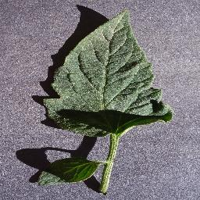

In [ ]:
# ==============================================================================
# PART 4: SAVE & INFERENCE
# ==============================================================================

# 1. SAVE THE MODEL
# -------------------------------------------------
save_path = "plant_doctor_rl_model.pth"
torch.save(model.state_dict(), save_path)
print(f"💾 Model saved to: {save_path}")
print("   (Download this file from the Files tab on the left if you want to keep it!)")

# 2. DEFINE INFERENCE FUNCTION
# -------------------------------------------------
def diagnose_plant(image_path, question_text="What is the pathology?"):
    model.eval()

    # Load and Preprocess Image
    try:
        image = Image.open(image_path).convert("RGB")
    except:
        print("❌ Could not load image.")
        return

    # Prepare Inputs
    inputs = processor(text=question_text, images=image, return_tensors="pt", padding="max_length", truncation=True)
    pix = inputs['pixel_values'].to(device)
    ids = inputs['input_ids'].to(device)
    mask = inputs['attention_mask'].to(device)

    # Generate Response (Using the smart greedy method for best coherence)
    print(f"\n🌱 Diagnosing Image: {os.path.basename(image_path)}...")

    # We use generate_greedy for the final report because it's more stable than sampling
    gen_ids = model.generate_greedy(pix, ids, mask, max_len=50)
    diagnosis = tokenizer.decode(gen_ids)

    print(f"🤖 Dr. AI says:\n{diagnosis}")

    # Show the image (Optional in Colab)
    try:
        display(image.resize((200, 200)))
    except:
        pass

# 3. RUN TEST ON A RANDOM IMAGE FROM DATASET
# -------------------------------------------------
import random

# Pick a random line from your jsonl file to find an image path
with open(jsonl_path, 'r') as f:
    lines = f.readlines()
    random_entry = json.loads(random.choice(lines))

test_image_path = os.path.join(image_root, random_entry['image'])
test_question = random_entry['question']

diagnose_plant(test_image_path, test_question)